In [4]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT brand_title, price_numeric, status, catalog_id, size_title, color1_id
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               """
data = pd.read_sql(sql_query, engine)
data

,brand_title,price_numeric,status,catalog_id,size_title,color1_id
0,Diesel,15.0,Bom,1845.0,XS / 34 / 6,9.0
1,Calvin Klein,15.0,Muito bom,1845.0,L / 40 / 12,9.0
2,Stradivarius,5.0,Muito bom,1079.0,S / 36 / 8,4.0
3,Stradivarius,7.0,Novo sem etiquetas,1043.0,M / 38 / 10,2.0
4,Pull & Bear,5.0,Novo sem etiquetas,190.0,S / 36 / 8,4.0
...,...,...,...,...,...,...
427804,CUIR,14.0,Satisfatório,1238.0,43,2.0
427805,Meltin Pot,14.0,Bom,1844.0,L / 40 / 12,9.0
427806,Diesel,18.0,Muito bom,1845.0,M / 38 / 10,1.0
427807,Menglu,3.0,Bom,1066.0,Tamanho único,3.0


In [5]:
# inputs: count products, median price, std dev price, nunique catalog_id, ununique color1_id, ununique size_title
# Group by brand_title and calculate various statistics
catalog_stats = data.groupby('catalog_id').agg({
    'price_numeric': ['count', 'median', 'std'],
    'brand_title': 'nunique',
    'color1_id': 'nunique',
    'size_title': 'nunique'
})

# Rename columns for clarity
catalog_stats.columns = ['product_count', 'price_median', 'price_std', 'brand_title_unique', 'color1_id_unique', 'size_title_unique']

catalog_stats = catalog_stats[catalog_stats["product_count"] > 300]
catalog_stats

,product_count,price_median,price_std,brand_title_unique,color1_id_unique,size_title_unique
catalog_id,,,,,,
11.0,1502,5.0,7.956022,86,28,13
14.0,1149,3.0,13.322234,84,33,9
18.0,2310,6.0,35.121046,143,33,14
19.0,304,9.0,24.674465,22,11,1
20.0,878,5.0,20.233337,61,23,13
...,...,...,...,...,...,...
2954.0,580,17.5,42.212361,58,25,12
2955.0,440,9.0,16.978136,42,17,11
2956.0,677,8.0,11.964884,43,17,1


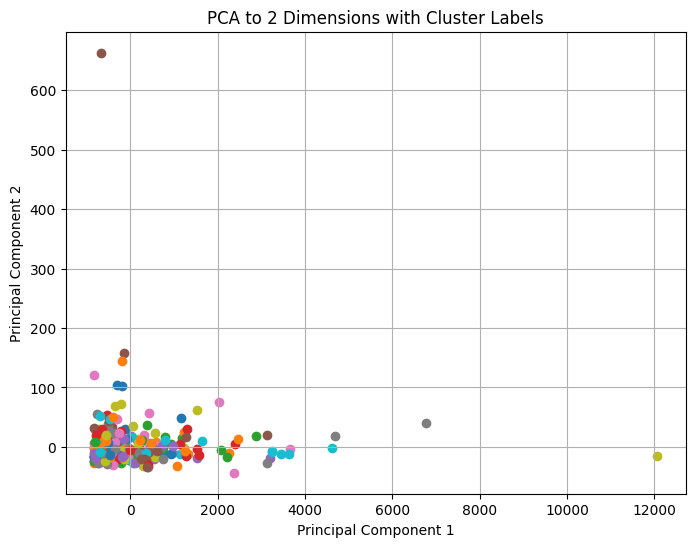

In [6]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(catalog_stats)

# Assign cluster labels to the transformed data
data_with_labels = pd.DataFrame(X_2d, index=catalog_stats.index, columns=['PC1', 'PC2'])

# Plot the transformed data with colors based on cluster labels
plt.figure(figsize=(8, 6))
for cluster_label in data_with_labels.index:
    plt.scatter(data_with_labels.loc[data_with_labels.index == cluster_label, 'PC1'],
                data_with_labels.loc[data_with_labels.index == cluster_label, 'PC2'],
                label=f'Cluster {cluster_label}')
    
plt.title('PCA to 2 Dimensions with Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)